File to compute lyapunov exponents from trained model and compare with true values. 

Models:

Hopf, Lorenz, Saddle node

In [1]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v2 as nodes
import models.DynamicalSystems as ds

In [4]:
lorenz = ds.Lorenz(sigma = 10.0, rho = 28.0, beta = 8.0/3.0)
hopf = ds.Hopf(rho=1.0, alpha = -1.0, omega=0.0, beta=-0.0)
sn = ds.saddlenode(a = -0.5)

In [5]:
model_sn = torch.load('models/SaddleNode_driven_neural_ODE_m1.pt')
model_hopf = torch.load('models/hopf_driven_neural_ODE_m1.pth')
model_lorenz = torch.load('models/lorenz_driven_neural_ODE_m1.pt', weights_only=False)

In [6]:
import lyapynov as lya 

In [11]:
lorenz_lya = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0]), t0 = 0, f=lambda x, t: lorenz.f_numpy(t, x), jac=lambda x, t: lorenz.jacobian_numpy(t, x), dt=0.01)

In [12]:
lya.LCE(system = lorenz_lya, p=1, n_forward=10_000, n_compute=20_000, keep=False)

array([0.91457665])

In [15]:
list = []

In [16]:
rho_pts = torch.arange(10, 28, 0.5)
for rho in tqdm(rho_pts):
    lorenz.rho = rho
    lorenz_lya = lya.ContinuousDS(x0 = np.array([1.0, 1.0, 1.0]), t0 = 0, f=lambda x, t: lorenz.f_numpy(t, x), jac=lambda x, t: lorenz.jacobian_numpy(t, x), dt=0.01)
    out = lya.LCE(system = lorenz_lya, p=1, n_forward=10_000, n_compute=20_000, keep=False)
    list.append(out)

100%|██████████| 36/36 [02:54<00:00,  4.86s/it]


Text(0.5, 0, '$\\rho$')

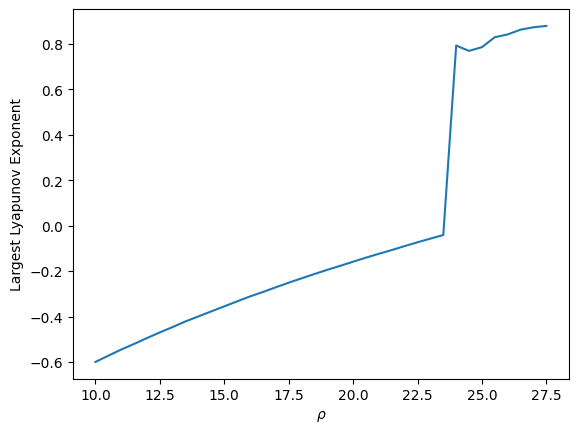

In [20]:
plt.plot(rho_pts, list)
plt.ylabel('Largest Lyapunov Exponent')
plt.xlabel(r'$\rho$')

In [ ]:
# From Model 

In [33]:
class neural_ODE_Lyapunov():
    def __init__(self, model): 
        self.model = model

    def f(self, x, t):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        dxdt = self.model(t, x_tensor)
        return dxdt.squeeze(0).detach().numpy()

    def jacobian(self, x, t):
        x = torch.tensor(x, dtype=torch.float32)
        func = lambda x, t=t: self.model(t, x)
        jacobian_matrix = torch.autograd.functional.jacobian(func=func, inputs=x)
        return jacobian_matrix.squeeze(0).detach().numpy()

In [34]:
model_lorenz.drdt = 0.0

In [35]:
node_lya = neural_ODE_Lyapunov(model = model_lorenz)

In [39]:
out = lya.LCE(system = lorenz_lya, p=1, n_forward=10_000, n_compute=20_000, keep=False)

IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)